<a href="https://colab.research.google.com/github/AnnieCRY/DS5230-project/blob/master/hierarchical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [16]:
%%capture
!wget -nc https://raw.githubusercontent.com/AnnieCRY/DS5230-project/master/relabel.py
import relabel

In [4]:
# download the supporting files from github
! rm -rf Audio_based_identification_beehive_states/
! git clone https://github.com/Tonyz4516/Audio_based_identification_beehive_states.git

! mv Audio_based_identification_beehive_states/Bee_NotBee_classification/* ./

Cloning into 'Audio_based_identification_beehive_states'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 118 (delta 0), reused 0 (delta 0), pack-reused 114
Receiving objects: 100% (118/118), 69.02 KiB | 4.06 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [5]:
%%capture
! pip install muda

In [6]:
# move zip file to colab vm
! cp -r gdrive/My\ Drive/5230Project/processed_data ./

cp: cannot open 'gdrive/My Drive/5230Project/processed_data/state_labels.gsheet' for reading: Operation not supported


In [17]:
relabel.modify_labels('/content/processed_data/dataset_BeeNoBee_5sec')

In [8]:
import os
import matplotlib.pyplot as plt
from utils import *
import scipy
import sklearn, librosa, mir_eval, IPython.display, urllib
import pandas as pd
import numpy as np

In [9]:
block_size = 5
path_workingFolder = '/content/processed_data/dataset_BeeNoBee_'+str(block_size)+'sec'+os.sep  # path where to save audio segments and labels files.
labels2read = 'labels_BeeNotBee_th0'
feature = 'MFCCs20'
sample_ids_test, sample_ids_train, sample_ids_val = get_samples_id_perSet(path_workingFolder+'split_random_0.json')

In [10]:
X_train = get_features_from_samples(path_workingFolder, sample_ids_train, 'MFCCs20', 'NO', 1)
X_val = get_features_from_samples(path_workingFolder, sample_ids_val, 'MFCCs20', 'NO', 1)
X_test = get_features_from_samples(path_workingFolder, sample_ids_test, 'MFCCs20', 'NO', 1)

In [11]:
def get_GT_labels_fromFiles(path_labels, sample_ids, labels2read) : #labels2read =  name of the label file
    labels = []
    fileAsdict={}
    
    with open(path_labels + labels2read+'.csv', 'r') as labfile:
        csvreader = csv.reader(labfile, delimiter=',')    
        for row in csvreader:
            if not row[0] == 'sample_name':
                fileAsdict[row[0]]=row[-1]   # row[-1] = '/missing queen/active' or 'bee/nobee'
                 
    for sample in sample_ids:
        labels.append(fileAsdict[sample[0:-4]])  #remove .wav extension

    return labels 

In [18]:
labels_train = get_GT_labels_fromFiles(path_workingFolder, sample_ids_train, labels2read)
Y_train = labels_train

In [ ]:
# labels_train = get_GT_labels_fromFiles(path_workingFolder, sample_ids_train, labels2read)
# Y_train= labels2binary('nobee', labels_train)
    
# labels_val = get_GT_labels_fromFiles(path_workingFolder, sample_ids_val, labels2read)
# Y_val= labels2binary('nobee', labels_val)
    
# labels_test = get_GT_labels_fromFiles(path_workingFolder, sample_ids_test, labels2read)
# Y_test= labels2binary('nobee', labels_test)

### hierchical clustering

In [40]:
df_train = pd.DataFrame(data=X_train)

In [41]:
from sklearn.preprocessing import normalize
train_scaled = normalize(df_train)
train_scaled = pd.DataFrame(train_scaled, columns=df_train.columns)
# train_scaled.head()

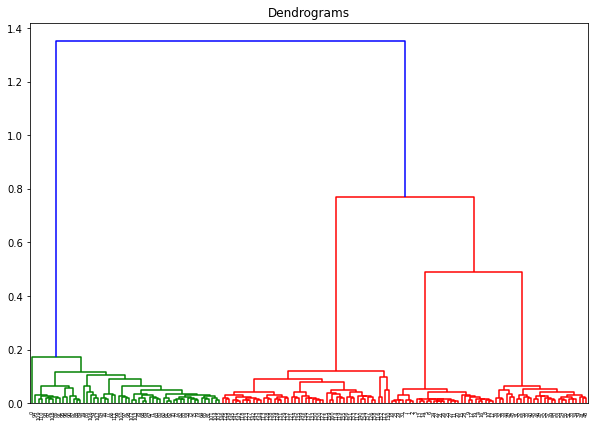

In [42]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7)) 
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(train_scaled, method='ward'))

In [43]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
Y_pred = cluster.fit_predict(train_scaled)

In [44]:
# PCA
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

In [45]:
pca = PCA(n_components = 3).fit_transform(train_scaled)
pca_df = pd.DataFrame(data = pca, columns = ['PC1', 'PC2', 'PC3'])

In [46]:
# true label
pca_df1 = pd.concat([pca_df, pd.DataFrame(Y_train, columns = ['label'])], axis = 1)
fig = px.scatter_3d(pca_df1, x='PC1', y='PC2', z='PC3',color='label')
fig.show()

In [47]:
# prediction
pca_df2 = pd.concat([pca_df, pd.DataFrame(Y_pred, columns = ['label'])], axis = 1)
fig2 = px.scatter_3d(pca_df2, x='PC1', y='PC2', z='PC3',color='label')
fig2.show()

#### evaluate

In [84]:
Y_relab = list()
for l in Y_train:
    if l == "unknown":
        Y_relab.append(0)
    elif l == "bee":
        Y_relab.append(1)
    else:
        Y_relab.append(2)

In [58]:
type(Y_pred[0])

numpy.int64

In [85]:
# confusion matrix
from sklearn import metrics
cm = metrics.confusion_matrix(Y_relab, Y_pred)
# cm_df = pd.DataFrame(cm, 
#             columns = ['Predicted Negative', 'Predicted Positive'],
#             index = ['Actual Negative', 'Actual Positive'])
# cm_df
cm

array([[21,  5, 12],
       [29, 39, 31],
       [ 7, 11,  6]])

In [63]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [86]:
precision_score(Y_relab, Y_pred, average='weighted')

0.541234630498162

In [87]:
recall_score(Y_relab, Y_pred, average='weighted')

0.40993788819875776

In [88]:
f1_score(Y_relab, Y_pred, average='weighted')

0.440298525604405

In [90]:
# precision recall curve only support binary

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from inspect import signature
precision, recall, threshold = precision_recall_curve(Y_relab, Y_pred)
average_precision = average_precision_score(Y_relab, Y_pred)
step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
plt.step(recall, precision, color='r', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='r', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

ValueError: ignored